## This notebook outlines the process for obtaining a forecasting model for the hydrometry level in River Arno in Italy, using the dataset for the Acea Smart Water Analytics competition. 

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib
import statsmodels as sm
import seaborn as sns
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error
from statsmodels.tsa.api import ARIMA
%matplotlib inline

### Data Preprocessing

#### The columns consist of:

    - daily rainfall values (in meters) in 14 different regions
    - Temperature (in Celcius)
    - Hydrometry (water level in meters)
    
    
#### The goal is to obtain a forecasting model for Hydrometry given past rainfall, hydrometry and temperature values. 
We start with constructing a daily forecasting model with daily hydrometry difference as the target, then construct a daily forecasting model with residual + trend components after a Seasonal-Trend decomposition</span>

#### Since entries before "01/01/2004" and after "01/07/2007" include missing values, we drop them. We also set the Date as the index of the pandas dataframe. 

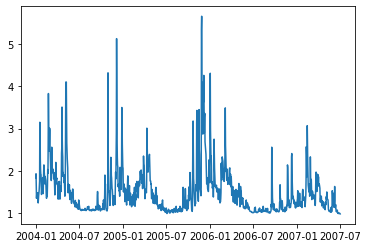

In [2]:
# read data 
df = pd.read_csv("acea-water-prediction/River_Arno.csv")
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)

df.drop(df[df.Date < pd.to_datetime("01/01/2004", dayfirst=True)].index, inplace=True)
df.drop(df[df.Date > pd.to_datetime("01/07/2007", dayfirst=True)].index, inplace=True)
df.fillna(0, inplace=True)
df.head()

df = df.set_index("Date")
df.head()

plt.plot(df["Hydrometry_Nave_di_Rosano"])

#### Split data between "01/01/2004" and "01/07/2007" into training, validation and test splits
#### Entries outside this range have many missing entries and negatively affect the forecasting performance

In [487]:
def split(data, train_frac=0.7, val_frac=0.30):
    
    # contiguous split
    train_delim = int(train_frac * len(data))
    val_delim = int((train_frac + val_frac) * len(data))

    indices = data.index
    start, end = indices[0], indices[train_delim - 1]
    train = data[start:end]
    
    start, end = indices[train_delim], indices[val_delim - 1]
    val = data[start:end]
    
    if val_delim < len(data):
        start = indices[val_delim]
        test = data[start:]
        
    else:
        test = []
    
    return train, val, test

In [489]:
train_df, val_df, test_df = split(df)
print("{} training samples, {} validation samples, {} test samples".format(len(train_df), len(val_df), len(test_df)))


894 training samples, 384 validation samples, 0 test samples


## EDA on rainfall data
### We examine rainfall series to check for large correlations and determine whether dimensionality reduction or regularization is required before applying linear regression with rainfall values as covariates. 

In [441]:
# represent rainfall data as column vectors of a matrix X 
columnVals = train_df.columns.map(lambda x: x.startswith("Rainfall"))

df_rainfall = train_df.filter(df.columns[columnVals], axis=1)
X_rain = df_rainfall.to_numpy()
N, d = X_rain.shape
print(N, d)

894 14


#### The correlation matrix of rainfall values in different regions suggests that we may leverage a lower dimensional representation of rainfall values on a given day. 

#### Rainfall in regions 0 to 5 are highly correlated with each other but have low correlation with rainfall values in regions 6 to 13. 
#### Similarly, rainfall in regions 6 to 13 are highly correlated with each other. 

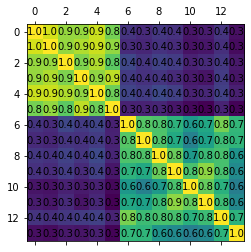

In [442]:
# compute mean rainfall vector 
mean_rainfall = X_rain.mean(axis=0, keepdims=True)

# Compute normalized feature vectors for rainfall data
X_rain_norml = X_rain - mean_rainfall
std_rainfall = np.sqrt(np.power(X_rain_norml, 2).mean(axis=0))[:, np.newaxis]
X_rain_norml = X_rain_norml / std_rainfall.T

corr_rain = X_rain_norml.T.dot(X_rain_norml) / N
fig, ax = plt.subplots()
ax.matshow(corr_rain)

for (i, j), z in np.ndenumerate(corr_rain):
    ax.text(j, i, '{:0.1f}'.format(z), ha='center', va='center')


### We perform PCA on rainfall data and plot the reconstruction error vs. the number of principal components chosen. 

Fraction of Error:  0.16102748399644493
Reconstruction Error:  2.4100589607366247


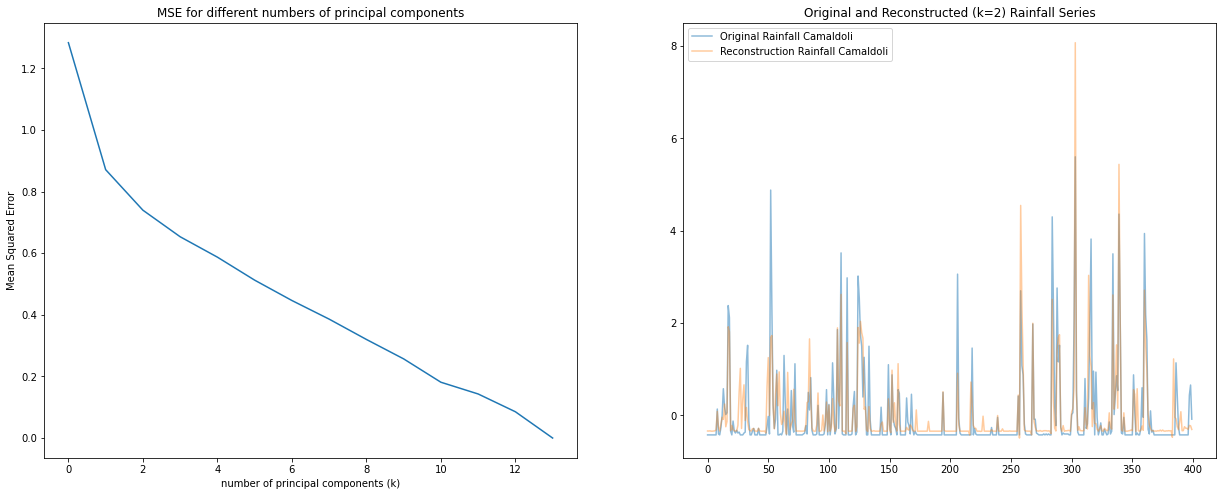

In [443]:
# Perform PCA on rainfall data 
u, s, vh = np.linalg.svd(corr_rain, full_matrices=True)

# Use the elbow method to choose the number of principal components 
errors = []
sigma = np.diag(s)

for k in range(1, X_rain_norml.shape[-1] + 1):
    proj = vh[:k, :].dot(X_rain_norml.T) 
    recon = u[:, :k].dot(proj) 
    diff = X_rain_norml - recon.T
    mse = np.linalg.norm(diff, ord=2, axis=-1).mean()
    errors.append(mse)
    

fig, ax = plt.subplots(1, 2)
fig.set_size_inches(21, 8)


ax[0].plot(errors)
ax[0].set_title("MSE for different numbers of principal components")
ax[0].set_xlabel("number of principal components (k)")
ax[0].set_ylabel("Mean Squared Error")

proj = vh[:2, :].dot(X_rain_norml.T) # k x N
recon = u[:, :2].dot(proj)

og = ax[1].plot(X_rain_norml[:400, -1], alpha=0.5, label="Original Rainfall Camaldoli")
re = ax[1].plot(recon.T[:400, -1], alpha=0.4, label="Reconstruction Rainfall Camaldoli")
ax[1].set_title("Original and Reconstructed (k=2) Rainfall Series")
ax[1].legend(loc="upper left")
recon_error = np.power(recon.T - X_rain_norml, 2).sum(axis=-1)

print("Fraction of Error: ", (recon_error / np.power(X_rain_norml, 2).sum(axis=-1)).mean())
print("Reconstruction Error: ", recon_error.mean())


#### PCA does not look like a reasonable choice for reducing the dimensionality of rainfall values. 
#### This fact is hinted at by the slow reduction in reconstruction error as the number of principal directions is increased. 
#### We also show below that days with heavy rainfall in one or more regions are not well captured by the two principal components. 
#### These values are expected to increase hydrometry levels and should therefore be adequately represented. 

/Users/elsariachi/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: Mean of empty slice.
  
/Users/elsariachi/opt/miniconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/elsariachi/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: Mean of empty slice.
  from ipykernel import kernelapp as app
/Users/elsariachi/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in log


Text(0.5, 1.0, 'MSE after PCA with k=2 vs. norm of rainfall features')

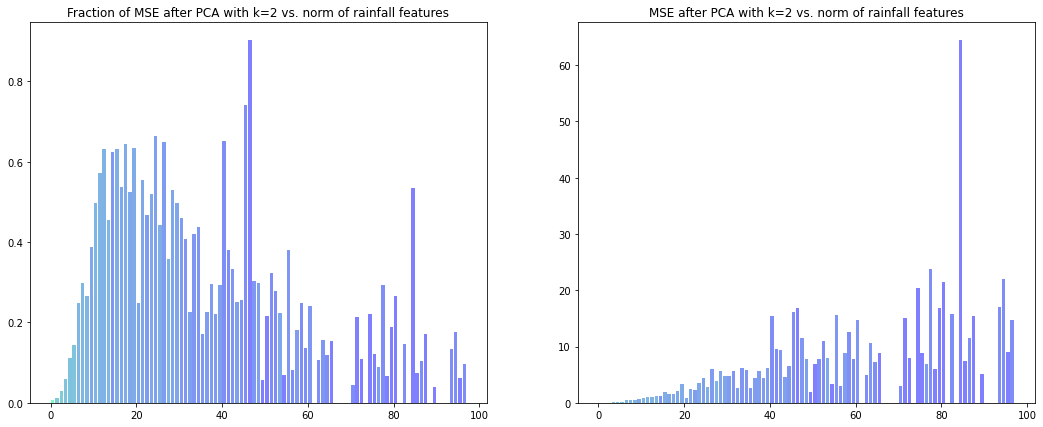

In [444]:
delim = [i for i in range(100)]

dist = np.linalg.norm(X_rain, ord=2, axis=-1)
recon_errors = np.power(recon.T - X_rain_norml, 2).sum(1)
frac_errors = recon_errors / np.power(X_rain_norml, 2).sum(axis=-1)

hydrometry = train_df["Hydrometry_Nave_di_Rosano"]
hist_errors = []
hist_frac_errors = []
hist_counts = []

for i, d in enumerate(delim[:-1]):
    indices = np.argwhere(np.logical_and(dist >= delim[i], dist < delim[i+1]))
    hist_frac_errors.append(frac_errors[indices].mean())
    hist_errors.append(recon_errors[indices].mean())
    hist_counts.append(len(indices))

x = [0.5 * (delim[i] + delim[i+1]) for i in range(99)]    

fig, ax = plt.subplots(1, 2)
fig.set_size_inches(18, 7)
hist_counts = np.log(np.array(hist_counts))
color = matplotlib.cm.get_cmap("winter")(hist_counts / max(hist_counts))
ax[0].bar(x=x, height=hist_frac_errors, alpha=0.5, color=color)
ax[0].set_title("Fraction of MSE after PCA with k=2 vs. norm of rainfall features")

ax[1].bar(x=x, height=hist_errors, alpha=0.5, color=color)
ax[1].set_title("MSE after PCA with k=2 vs. norm of rainfall features")



#### The bar graph above shows the mean reconstruction error (y-axis) for different magnitudes of rainfall feature vectors (x-axis). 
#### We see that at large distances, the mean reconstruction error is much larger. These points do not contribute much to the overall mean reconstruction error, but they have a large influence on hydrometry. 

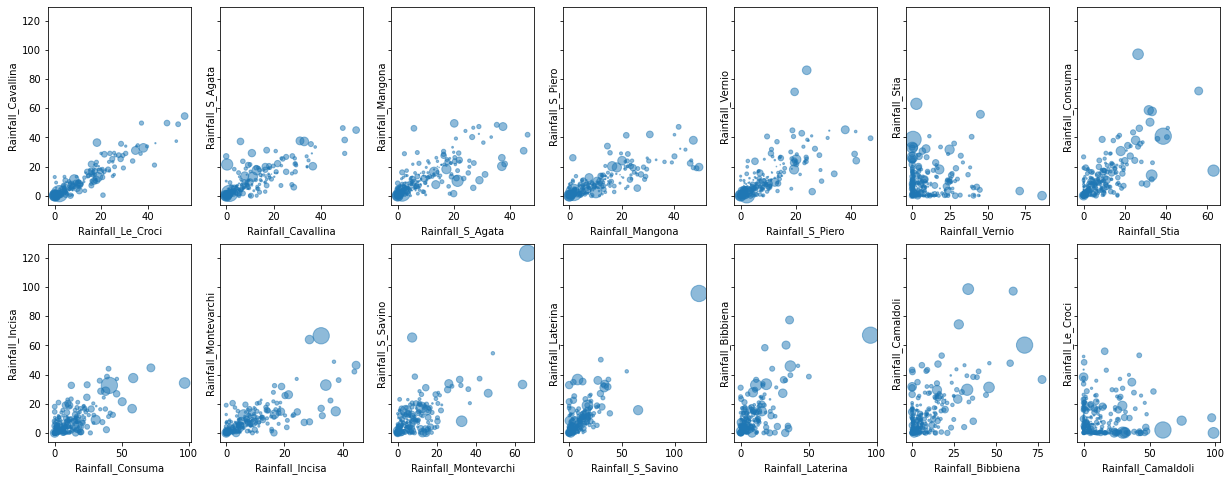

In [445]:
N, d = X_rain_norml.shape
fig, ax = plt.subplots(2, 7, sharex=False, sharey=True)
fig.set_size_inches(21, 8)
recon_errors = np.power(recon.T - X_rain_norml, 2).sum(1) 
for i, col in enumerate(df_rainfall.columns):
    j = i + 1 if i < d - 1 else 0
    ax[i // 7, i % 7].scatter(df_rainfall[col], df_rainfall[df_rainfall.columns[j]], alpha=0.5, s=2 * recon_errors) 
    ax[i // 7, i % 7].set_xlabel(col)
    ax[i // 7, i % 7].set_ylabel(df_rainfall.columns[j])

#### The figure above shows scatter plots of rainfall values in different regions. For most pairs of regions, we notice a strong correlation and a linear relationship for small rainfall values. Larger rainfall values, at one or more regions deviate further from the linear relationship and have a larger reconstruction error from the top 2 principal components, as demonstrated by the larger marker sizes. 

### Inspection of Time Dependence

#### Since hydrometry is seasonal, we use the difference between hydrometry values at consecutive days as the target. 


Text(0.5, 1.0, 'Hydrometry Difference')

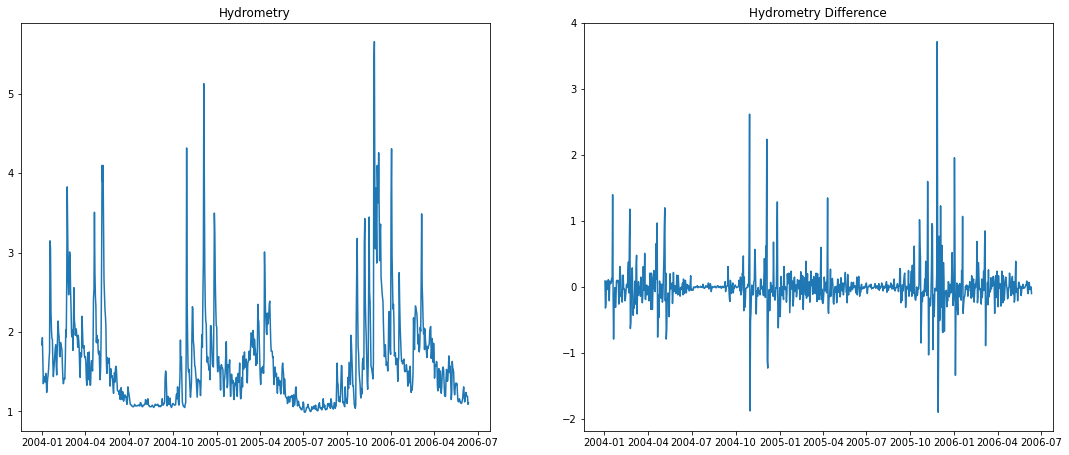

In [446]:
hydrometry = train_df["Hydrometry_Nave_di_Rosano"]
hydrometry.head()

fig, ax = plt.subplots(1, 2, squeeze=False)

fig.set_size_inches(18.5, 7.5)

ax[0, 0].plot(hydrometry)
ax[0, 0].set_title("Hydrometry")

ax[0, 0].set_aspect("auto")
ax[0, 1].set_aspect("auto")

hydro_diff = (hydrometry - hydrometry.shift(1))[1:-1]
ax[0, 1].plot(hydro_diff)
ax[0, 1].set_title("Hydrometry Difference")

### We plot the autocovariance functions of "Hydrometry" and "Hydrometry Difference" to obtain a heuristic for the order p of the AR(p) model. 

### Note that the PACF computes the correlation between values at different time lags while accounting for the correlation between values at smaller time lags, and is a better indicator of the required order p. 

Text(0.5, 1.0, 'PACF Hydrometry Difference')

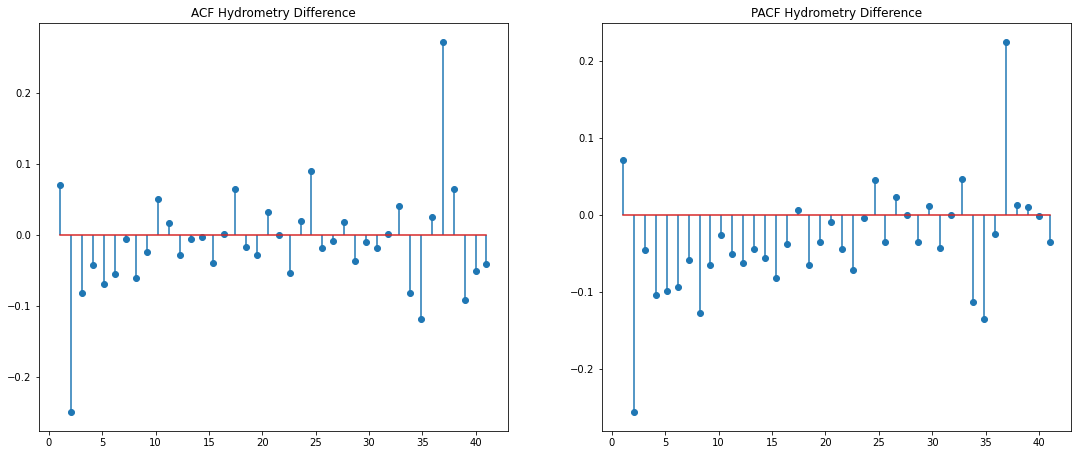

In [447]:
x = np.linspace(0, 41, 41)
fig, ax = plt.subplots(1, 2, squeeze=False)
fig.set_size_inches(18.5, 7.5)

acov = sm.tsa.stattools.acf(hydro_diff, fft=False, nlags=40)
ax[0, 0].stem(x[1:], acov[1:], use_line_collection=True)
ax[0, 0].set_title("ACF Hydrometry Difference")

pacov = sm.tsa.stattools.pacf(hydro_diff,nlags=40)
ax[0, 1].stem(x[1:], pacov[1:], use_line_collection=True)
ax[0, 1].set_title("PACF Hydrometry Difference")

#### The following plots show the cross-covariance at different time-lags between hydrometry difference and the top-2 principal components of rainfall values. Unlike the cross-covariance plots using the standardized rainfall values, we cannot deduce a clear order for the regression model. 

Text(0.5, 1.0, 'Cross-Covariance with second principal component')

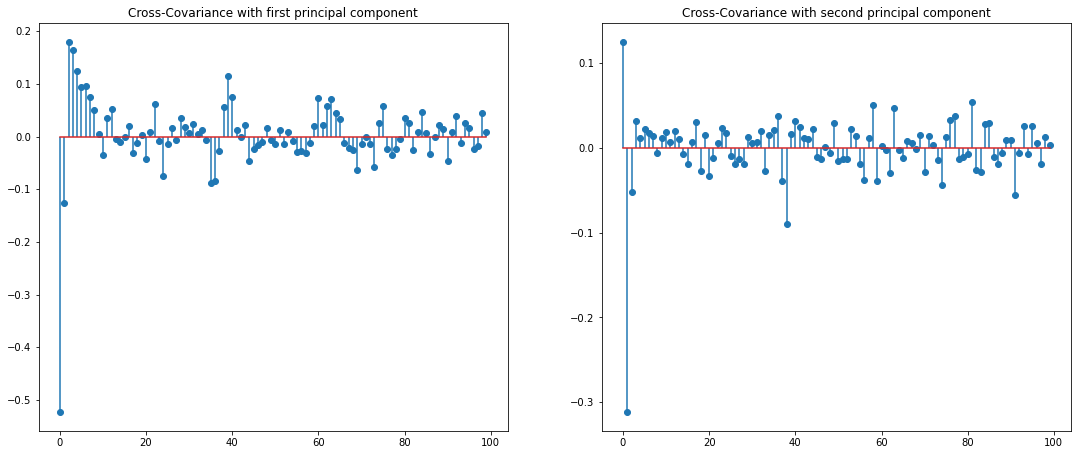

In [448]:
# compute cross-covariance between hydrometry difference and rainfall representations
# rainfall was projected onto 2 principal components 
x = np.linspace(0, 99, 100)
fig, ax = plt.subplots(1, 2, squeeze=False)
fig.set_size_inches(18.5, 7.5)

ccov_1 = sm.tsa.stattools.ccovf(hydro_diff, proj.T[1:-1, 0])
ccov_2 = sm.tsa.stattools.ccovf(hydro_diff, proj.T[1:-1, 1])

ax[0, 0].stem(x, ccov_1[0:100], use_line_collection=True)
ax[0, 0].set_title("Cross-Covariance with first principal component")
ax[0, 1].stem(x, ccov_2[0:100], use_line_collection=True)
ax[0, 1].set_title("Cross-Covariance with second principal component")

### We plot the cross-covariance between "Hydrometry Difference" and standardized rainfall values at different time-lags. Notice that "Hydrometry Difference" has a large positive covariance with rainfall in regions 0 to 5 at lag 1, which is not present for rainfall in regions 6 to 13. The negative cross-covariance values at larger time-lags may be due to decreasing hydrometry levels after an initial rise due to rainfall. 

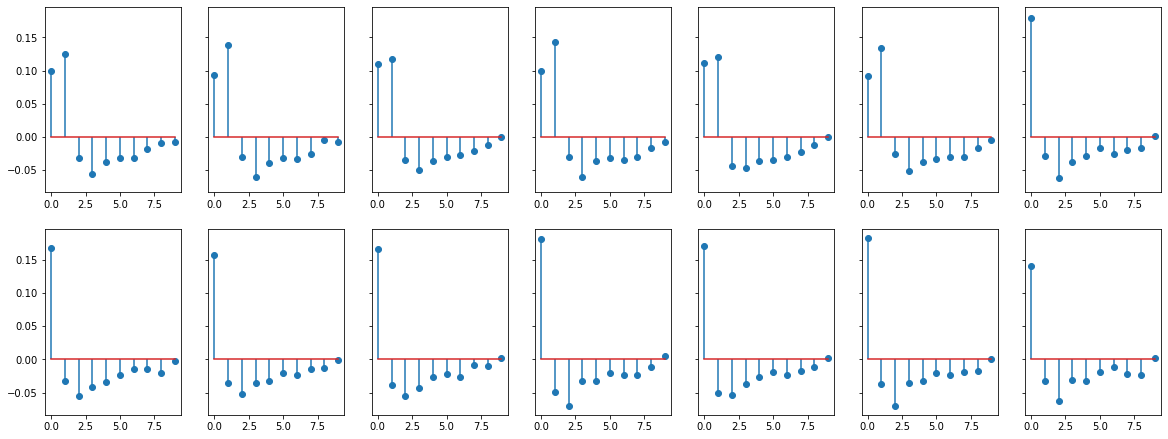

In [449]:
x = np.linspace(0, 9, 10)

fig, ax = plt.subplots(2, 7, squeeze=True, sharey=True)
fig.set_size_inches(20, 7.5)

for i in range(X_rain_norml.shape[-1]):
    ccov = sm.tsa.stattools.ccovf(hydro_diff, X_rain_norml[1:-1, i])
    ax[i // 7, i % 7].stem(x, ccov[:10], use_line_collection=True)

### Feature Engineering for Rainfall Series

#### While the cross-covariance between "Hydrometry Difference" and standardized rainfall values are more easily interpretable, the rainfall entries are still highly correlated which makes it difficult for linear regression to converge. We construct a lower dimensional rainfall feature vector below. 

#### Our resulting rainfall features are 2-dimensional where the first component is the norm of rainfall in regions 0 to 5, and the second component is the norm of rainfall in regions 6 to 13. 

Text(0.5, 1.0, 'Cross-Covariance with second rainfall feature')

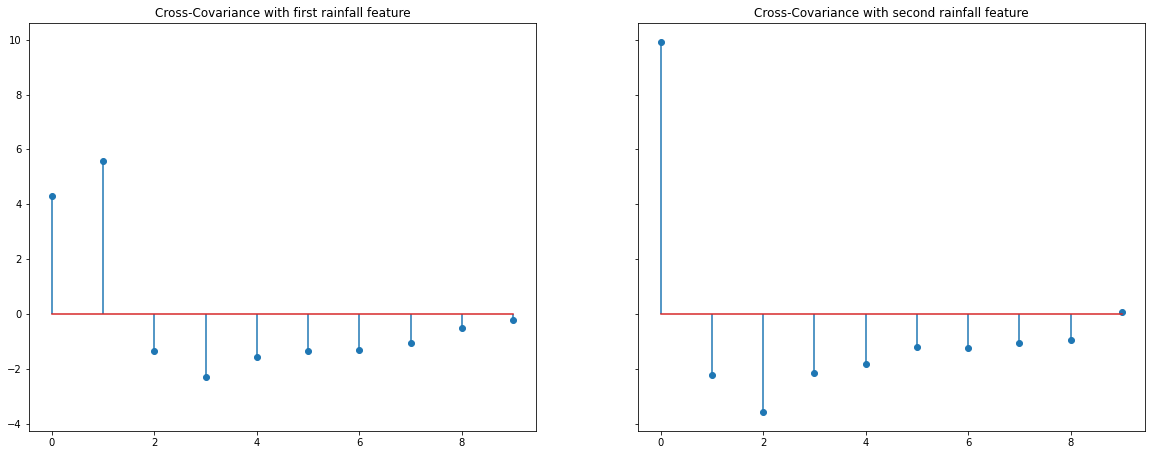

In [450]:
# split rainfall into two components, one component is a function of rainfall in region 1: columns 0 to 5 
# and the second component is a function of rainfall in region 2: columns 6 to 13 
X_rain_1 = np.power(X_rain[:, 0:6], 1).sum(-1)
X_rain_2 = np.power(X_rain[:, 6:], 1).sum(-1)

x = np.linspace(0, 9, 10)

fig, ax = plt.subplots(1, 2, squeeze=True, sharey=True)
fig.set_size_inches(20, 7.5)

ccov = sm.tsa.stattools.ccovf(hydro_diff, X_rain_1[1:-1])
ax[0].stem(x, ccov[:10], use_line_collection=True)
ax[0].set_title("Cross-Covariance with first rainfall feature")

ccov = sm.tsa.stattools.ccovf(hydro_diff, X_rain_2[1:-1])
ax[1].stem(x, ccov[:10], use_line_collection=True)
ax[1].set_title("Cross-Covariance with second rainfall feature")

### We therefore choose to use rainfall features up to lag 6. 

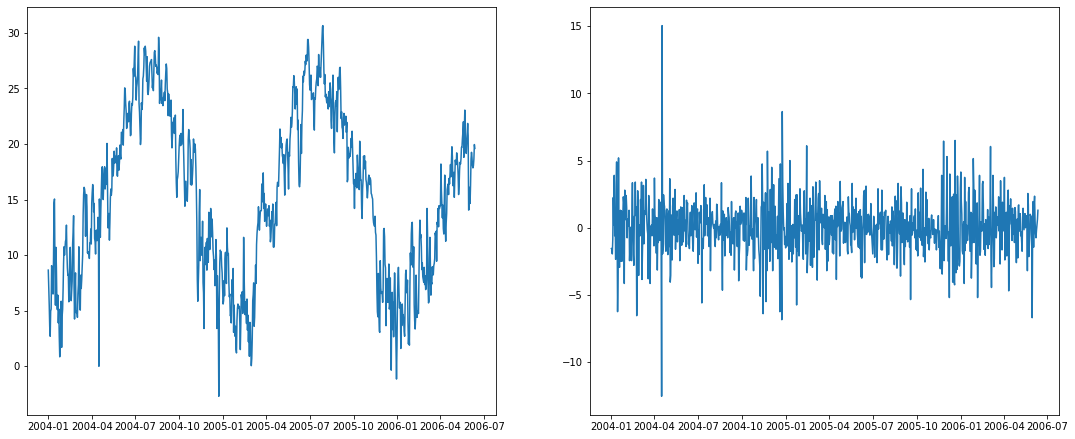

In [451]:
# temperature
temp = train_df["Temperature_Firenze"]
temp_diff = (temp - temp.shift(1))[1:-1]

fig, ax = plt.subplots(1, 2, squeeze=False)
fig.set_size_inches(18.5, 7.5)

ax[0, 0].plot(temp)
ax[0, 1].plot(temp_diff)

### Cross-Covariance between "Hydrometry Difference" and "Temperature" as well as "Temperature Difference" are too small. 

<StemContainer object of 3 artists>

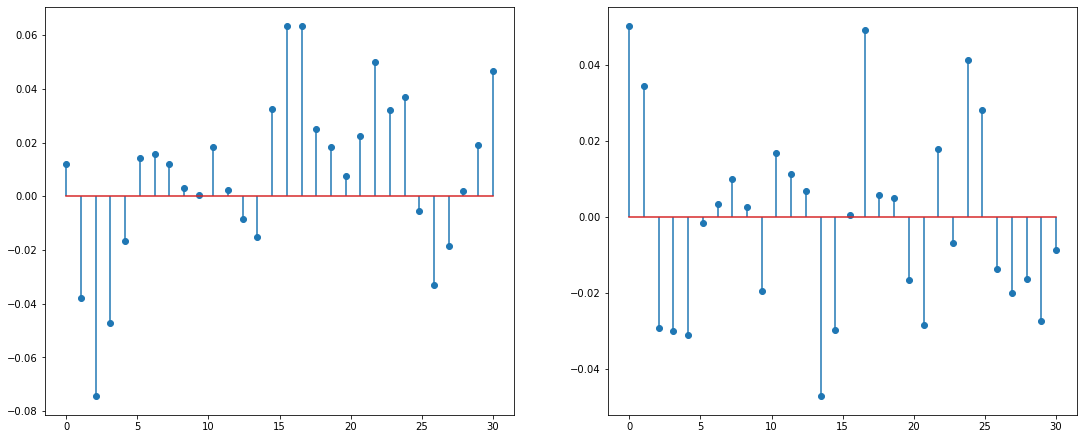

In [452]:
# compute cross-covariance between hydrometry difference and temperature
x = np.linspace(0, 30, 30)
fig, ax = plt.subplots(1, 2, squeeze=False)
fig.set_size_inches(18.5, 7.5)


ccov = sm.tsa.stattools.ccovf(hydro_diff, temp[1:-1])
ax[0, 0].stem(x, ccov[0:30], use_line_collection=True)


ccov = sm.tsa.stattools.ccovf(hydro_diff, temp_diff)
ax[0, 1].stem(x, ccov[0:30], use_line_collection=True)

            hydrometry_diff
Date                       
2004-01-01              NaN
2004-01-02             0.09
2004-01-03            -0.32
2004-01-04            -0.26
2004-01-05             0.09
...                     ...
2007-06-27             0.00
2007-06-28             0.00
2007-06-29            -0.01
2007-06-30             0.00
2007-07-01            -0.01

[1278 rows x 1 columns]


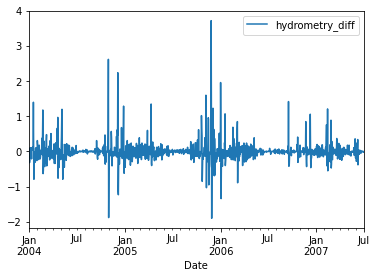

In [453]:
hydrometry = df["Hydrometry_Nave_di_Rosano"]
target = pd.DataFrame({"hydrometry_diff": (hydrometry - hydrometry.shift(1))})
target.plot()
print(target)

In [490]:
def get_train_features(dataframe, max_lag):
    
    columnVals = dataframe.columns.map(lambda x: x.startswith("Rainfall"))
    df_rainfall = dataframe.filter(df.columns[columnVals], axis=1)
    X_rain = df_rainfall.to_numpy()
    
    # split rainfall into two components, one component is a function of rainfall in region 1: columns 0 to 5 
    # and the second component is a function of rainfall in region 2: columns 6 to 13 
    rainfall_1 = np.linalg.norm(X_rain[:, 0:6], ord=2, axis=-1) / 100
    rainfall_2 = np.linalg.norm(X_rain[:, 6:], ord=2, axis=-1) / 100

    data = {"rainfall_1": rainfall_1[max_lag+1:],
            "rainfall_2": rainfall_2[max_lag+1:]}
        
    for i in range(1, max_lag + 1):
        # use max_lag-i + 1 as starting index for series delayed by i steps
        data["rainfall_2_lag_{}".format(i)] = rainfall_2[max_lag-i+1:-i]
        data["rainfall_1_lag_{}".format(i)] = rainfall_1[max_lag-i+1:-i]
        
    hydrometry = dataframe["Hydrometry_Nave_di_Rosano"]
    target = pd.DataFrame({"hydrometry_diff": (hydrometry - hydrometry.shift(1))[max_lag+1:]}, 
                          index=train_df.index[max_lag+1:])
    
    exog = pd.DataFrame(data=data, index=target.index)
    
    return exog, target


def get_val_features(train_df, val_df, max_lag):
    
    columnVals = train_df.columns.map(lambda x: x.startswith("Rainfall"))
    
    df_rainfall = train_df[-max_lag:].filter(df.columns[columnVals], axis=1)
    df_rainfall = pd.concat([df_rainfall, val_df.filter(df.columns[columnVals], axis=1)])
    
    X_rain = df_rainfall.to_numpy()
    
    rainfall_1 = np.linalg.norm(X_rain[:, 0:6], ord=2, axis=-1) / 100
    rainfall_2 = np.linalg.norm(X_rain[:, 6:], ord=2, axis=-1) / 100

    # since prev values is found in training set, we don't need to shift by 1
    data = {"rainfall_1": rainfall_1[max_lag:],
            "rainfall_2": rainfall_2[max_lag:]}
        
    for i in range(1, max_lag + 1):
        data["rainfall_2_lag_{}".format(i)] = rainfall_2[max_lag-i:-i]
        data["rainfall_1_lag_{}".format(i)] = rainfall_1[max_lag-i:-i]
        
    hydrometry = pd.concat([train_df["Hydrometry_Nave_di_Rosano"][-1:], val_df["Hydrometry_Nave_di_Rosano"]])
    target = pd.DataFrame({"hydrometry_diff": (hydrometry - hydrometry.shift(1))[1:]}, 
                          index=val_df.index)
    
    exog = pd.DataFrame(data=data, index=target.index)
    
    return exog, target


def get_forecast(exog, target, results): 
    
    pred = []
    gt = []
    for d in exog.index:
        test_data = exog.loc[d]
        forecast = results.forecast(exog=test_data) 
        
        # update internal state with gt target 
        # idx = pd.period_range(start=d, periods=1, freq='D')
        results = results.append(target.loc[[d]], exog=exog.loc[[d]])
        
        pred.append(forecast[0])
        gt.append(target.loc[d])
    
    fig, ax = plt.subplots()
    ax.plot(pred, alpha=0.5, label="forecast")
    ax.plot(gt, alpha=0.5, label="target")
    ax.legend(loc="upper left")
    
    pred = np.array(pred)
    gt = np.array(target)
    mse = np.power(pred - gt, 2).mean()
    mae = np.abs(pred - gt).mean()
    
    print("MSE: {}".format(mse))
    print("MAE: {}".format(mae))
    

In [491]:
exog, target = get_train_features(train_df, max_lag=3)
exog.head()
target.head()

,hydrometry_diff
Date,
2004-01-05,0.09
2004-01-06,-0.02
2004-01-07,-0.04
2004-01-08,-0.01
2004-01-09,0.11


In [492]:
model = ARIMA(endog=target, exog=exog, order=(2, 0, 2)) #(p, d, q)
results = model.fit()
results.summary()

/Users/elsariachi/opt/miniconda3/lib/python3.7/site-packages/statsmodels-0.13.0.dev0+241.g2228133e6-py3.7-macosx-10.7-x86_64.egg/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/elsariachi/opt/miniconda3/lib/python3.7/site-packages/statsmodels-0.13.0.dev0+241.g2228133e6-py3.7-macosx-10.7-x86_64.egg/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/elsariachi/opt/miniconda3/lib/python3.7/site-packages/statsmodels-0.13.0.dev0+241.g2228133e6-py3.7-macosx-10.7-x86_64.egg/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/elsariachi/opt/miniconda3/lib/python3.7/site-packages/statsmodels-0.13.0.dev0+241.g2228133e6-py3.7-macosx-10.7-x86_64.egg/statsmodels/base/model

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:        hydrometry_diff   No. Observations:                  890
Model:                 ARIMA(2, 0, 2)   Log Likelihood                 117.421
Date:                Thu, 11 Mar 2021   AIC                           -206.843
Time:                        23:13:52   BIC                           -139.766
Sample:                    01-05-2004   HQIC                          -181.205
                         - 06-12-2006                                         
Covariance Type:                  opg                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -0.0223      0.005     -4.226      0.000      -0.033      -0.012
rainfall_1           0.2237      0.031      7.126      0.000       0.162       0.285
rainfall_2           0.8584      0.026     32.907      0.000       0.807       0.910
rainfall_2_lag_1    -0.3981      0.029    -13.835      0.000      -0.454      -0.342
rainfall_1_lag_1     0.2887      0.038      7.689      0.000       0.215       0.362
rainfall_2_lag_2    -0.2746      0.051     -5.404      0.000      -0.374      -0.175
rainfall_1_lag_2    -0.1041      0.045     -2.333      0.020      -0.192      -0.017
rainfall_2_lag_3    -0.1855      0.037     -5.020      0.000      -0.258      -0.113
rainfall_1_lag_3    -0.1196      0.064     -1.860      0.063      -0.246       0.006
ar.L1                0.1476      0.138      1.067      0.286      -0.123       0.419
ar.L2                0.1582      0.111      1.432      0.152      -0.058       0.375
ma.L1               -0.3137      0.133     -2.355      0.019      -0.575      -0.053
ma.L2               -0.4824      0.125     -3.862      0.000      -0.727      -0.238
sigma2               0.0449      0.001     33.895      0.000       0.042       0.047
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              6159.31
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               1.50   Skew:                             1.23
Prob(H) (two-sided):                  0.00   Kurtosis:                        15.65
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

MSE: 0.08447373627365201
MAE: 0.1726300776543141


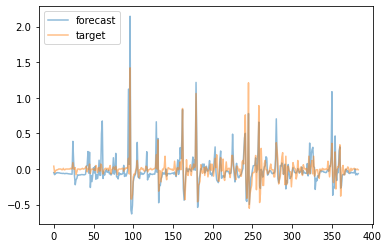

In [494]:
train_exog, train_target = get_train_features(train_df,max_lag=3)
exog, target = get_val_features(train_df, val_df, max_lag=3)

d = exog.index[1]

get_forecast(exog, target, results)

#### Over time, errors in daily prediction of hydrometry difference add up to result in large errors in the overall hydrometry forecast. 
#### Additionally, the river's response to rainfall may not be consistent across different hydrometry levels. 
#### In the following experiments, we examine the forecasting performance for the residual and trend components of hydrometry. 

Text(0.5, 1.0, 'Hydrometry Residual')

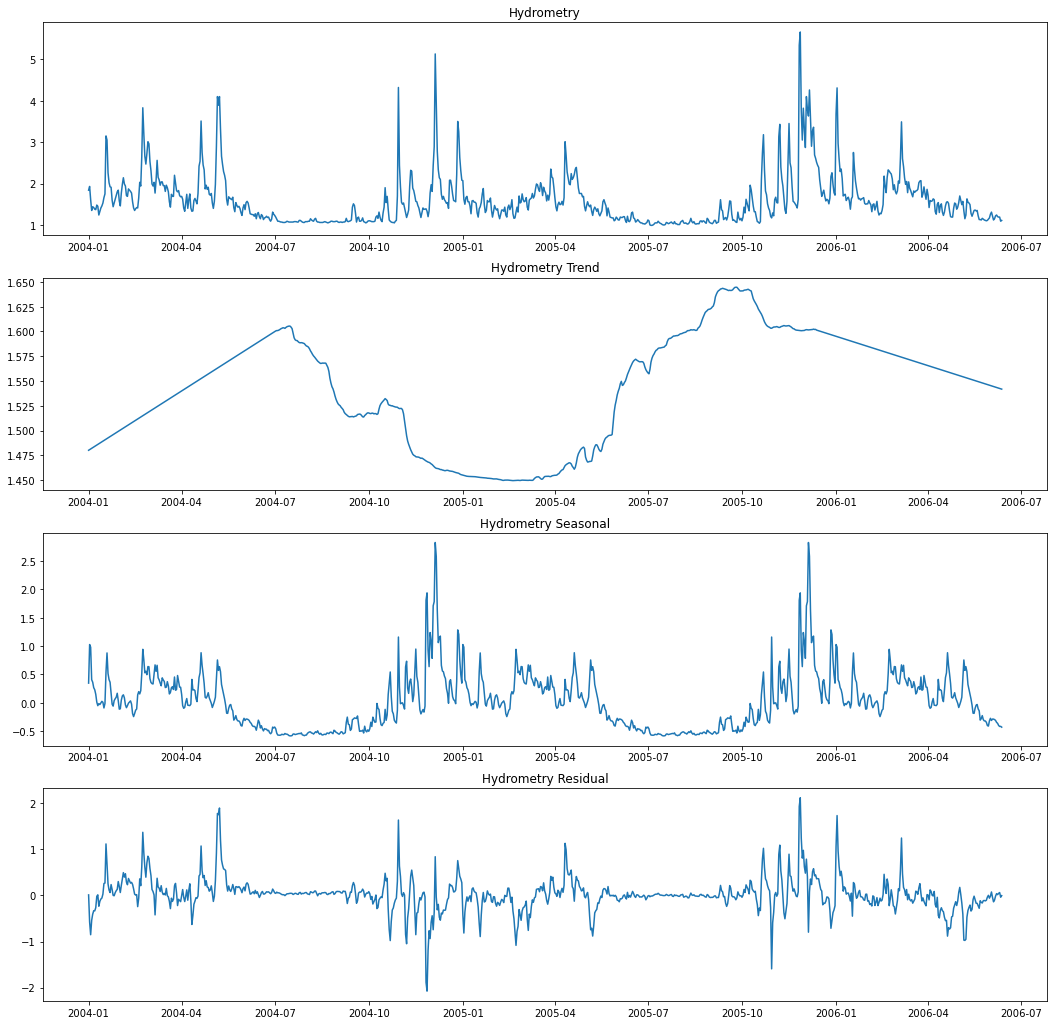

In [403]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomp = seasonal_decompose(train_df["Hydrometry_Nave_di_Rosano"], period=365, model='additive', extrapolate_trend=1)

fig, ax = plt.subplots(4, 1)
fig.set_size_inches(18, 18)
ax[0].plot(train_df["Hydrometry_Nave_di_Rosano"])
ax[0].set_title("Hydrometry")

ax[1].plot(decomp.trend)
ax[1].set_title("Hydrometry Trend")

ax[2].plot(decomp.seasonal)
ax[2].set_title("Hydrometry Seasonal")

ax[3].plot(decomp.resid)
ax[3].set_title("Hydrometry Residual")

### We use a rolling mean to smooth out the seasonal component, good forecasting performance could not be achieved with the unfiltered seasonal component. 

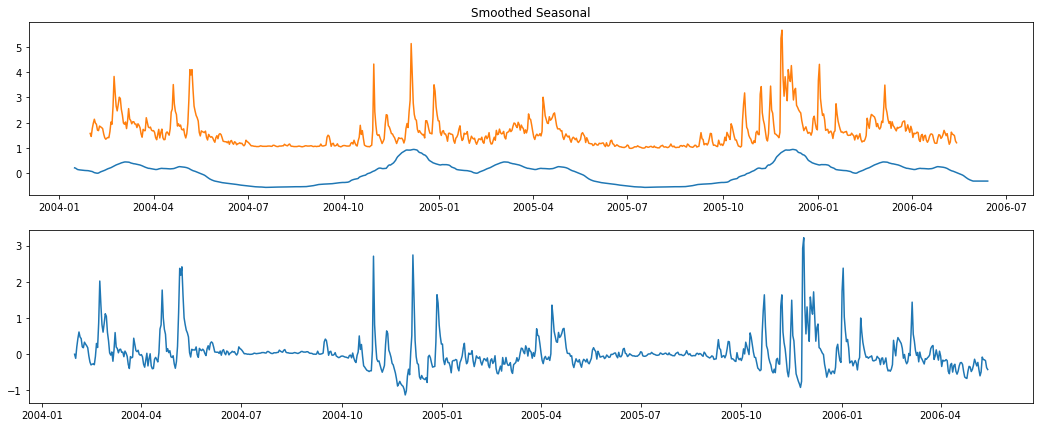

In [192]:
season_cycle = decomp.seasonal.rolling(window=30, center=True, win_type="gaussian").mean(std=15.).fillna(method="ffill")

fig, ax = plt.subplots(2, 1)
fig.set_size_inches(18, 7)
ax[0].plot(season_cycle)
ax[0].plot(train_df["Hydrometry_Nave_di_Rosano"][30:-30])
ax[0].set_title("Smoothed Seasonal")
ax[1].plot(train_df["Hydrometry_Nave_di_Rosano"][30:-30] - decomp.trend[30:-30] - season_cycle)

#### To forecast the trend and residual component as a function of rainfall features, we should encode the seasonal component as a numpy array to be added to our forecasts on the validation and test data. 

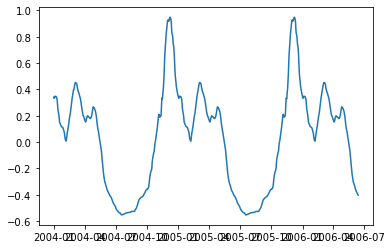

In [193]:
year = '2005'
season_cycle = season_cycle['2005-01-01':'2005-12-31']


# this function reads a date and returns the appropriate value for the seasonal component 
def date_to_seasonal(date):
    month = date.month
    day = date.day
    
    if day == 29 and month == 2:
        day = 28
        
    date = "{}-{}-{}".format(year, month, day)
    return season_cycle[pd.to_datetime(date, dayfirst=False)]

def build_seasonal(dataframe):
    indices = dataframe.index
    seasonal = []
    for i in indices:
        s = date_to_seasonal(i)
        seasonal.append(s)
    
    return pd.Series(seasonal, index=indices)

plt.plot(build_seasonal(train_df))

### We proceed to compute the ACF and PACF of the Hydrometry Residual 

Text(0.5, 1.0, 'PACF Hydrometry Residual')

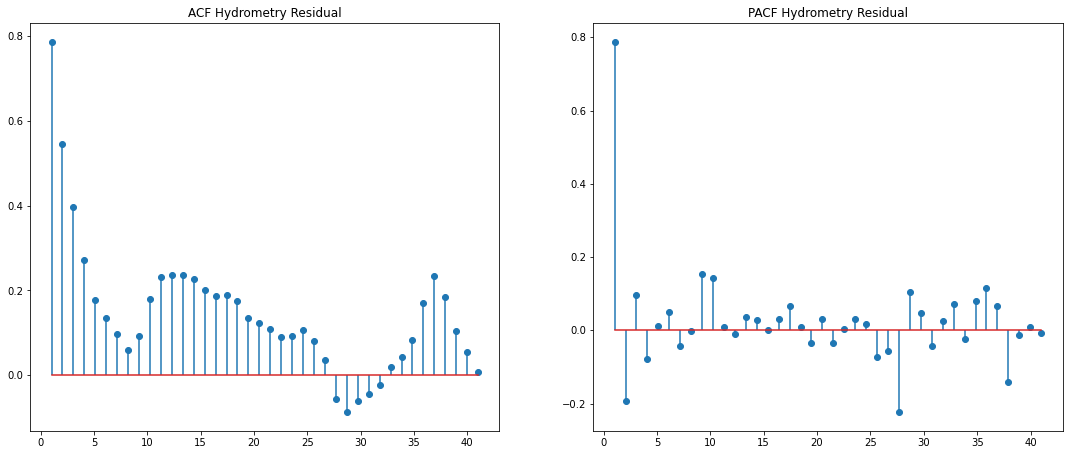

In [172]:
x = np.linspace(0, 41, 41)
fig, ax = plt.subplots(1, 2, squeeze=False)
fig.set_size_inches(18.5, 7.5)

acov = sm.tsa.stattools.acf(decomp.resid, fft=False, nlags=40)
ax[0, 0].stem(x[1:], acov[1:], use_line_collection=True)
ax[0, 0].set_title("ACF Hydrometry Residual")

pacov = sm.tsa.stattools.pacf(decomp.resid, nlags=40)
ax[0, 1].stem(x[1:], pacov[1:], use_line_collection=True)
ax[0, 1].set_title("PACF Hydrometry Residual")

### We examine the CCF between the Hydrometry Residual and Rainfall features to get an idea for the maximum lag required for rainfall features. 

Text(0.5, 1.0, 'Cross-Covariance with second rainfall feature')

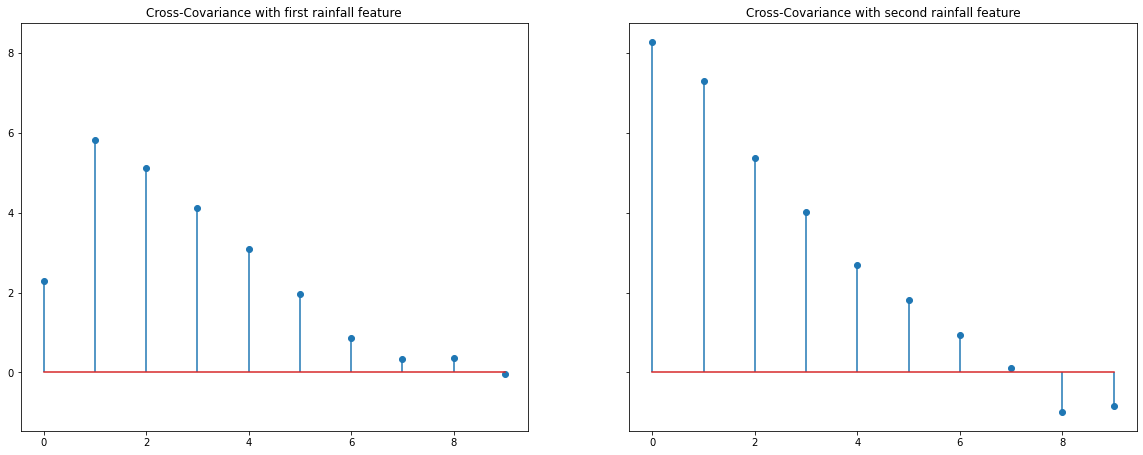

In [173]:
X_rain_1 = np.power(X_rain[:, 0:6], 1).sum(-1)
X_rain_2 = np.power(X_rain[:, 6:], 1).sum(-1)

x = np.linspace(0, 9, 10)

fig, ax = plt.subplots(1, 2, squeeze=True, sharey=True)
fig.set_size_inches(20, 7.5)

ccov = sm.tsa.stattools.ccovf(decomp.resid + decomp.trend, X_rain_1)
ax[0].stem(x, ccov[:10], use_line_collection=True)
ax[0].set_title("Cross-Covariance with first rainfall feature")

ccov = sm.tsa.stattools.ccovf(decomp.resid + decomp.trend, X_rain_2)
ax[1].stem(x, ccov[:10], use_line_collection=True)
ax[1].set_title("Cross-Covariance with second rainfall feature")

### We rewrite the get_feature method to use the residual from the STL decomposition as the target

In [194]:
def get_features_with_residual(dataframe, cycle, max_lag):
    
    columnVals = dataframe.columns.map(lambda x: x.startswith("Rainfall"))
    df_rainfall = dataframe.filter(df.columns[columnVals], axis=1)
    X_rain = df_rainfall.to_numpy()
    
    # split rainfall into two components, one component is a function of rainfall in region 1: columns 0 to 5 
    # and the second component is a function of rainfall in region 2: columns 6 to 13 
    rainfall_1 = np.linalg.norm(X_rain[:, 0:6], ord=1, axis=-1) / 100
    rainfall_2 = np.linalg.norm(X_rain[:, 6:], ord=1, axis=-1) / 100
    
    data = {"rainfall_1": rainfall_1[max_lag:],
            "rainfall_2": rainfall_2[max_lag:]}
        
    for i in range(1, max_lag + 1):
        data["rainfall_2_lag_{}".format(i)] = rainfall_2[max_lag-i:-i]
        data["rainfall_1_lag_{}".format(i)] = rainfall_1[max_lag-i:-i]
        
    hydrometry = dataframe["Hydrometry_Nave_di_Rosano"]
    
    # subtract seasonal component 
    target = hydrometry - build_seasonal(hydrometry)
    target = target[max_lag:]
    
    #decomp = seasonal_decompose(hydrometry, period=365, model='additive', extrapolate_trend='freq')
    #target = decomp.resid[max_lag:] + decomp.trend[max_lag:]
    
    exog = pd.DataFrame(data=data, index=target.index)
    
    return exog, target

In [195]:
exog, target = get_features_with_residual(train_df, season_cycle, max_lag=3)
model = ARIMA(endog=target, exog=exog, order=(5, 0, 5)) #(p, d, q)
results = model.fit()
results.summary()

/Users/elsariachi/opt/miniconda3/lib/python3.7/site-packages/statsmodels-0.13.0.dev0+241.g2228133e6-py3.7-macosx-10.7-x86_64.egg/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/elsariachi/opt/miniconda3/lib/python3.7/site-packages/statsmodels-0.13.0.dev0+241.g2228133e6-py3.7-macosx-10.7-x86_64.egg/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/elsariachi/opt/miniconda3/lib/python3.7/site-packages/statsmodels-0.13.0.dev0+241.g2228133e6-py3.7-macosx-10.7-x86_64.egg/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/elsariachi/opt/miniconda3/lib/python3.7/site-packages/statsmodels-0.13.0.dev0+241.g2228133e6-py3.7-macosx-10.7-x86_64.egg/statsmodels/base/model

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  892
Model:                 ARIMA(5, 0, 5)   Log Likelihood                 151.106
Date:                Thu, 11 Mar 2021   AIC                           -262.213
Time:                        16:10:42   BIC                           -166.344
Sample:                    01-04-2004   HQIC                          -225.574
                         - 06-13-2006                                         
Covariance Type:                  opg                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const                1.3336      0.110     12.160      0.000       1.119       1.549
rainfall_1           0.0585      0.014      4.223      0.000       0.031       0.086
rainfall_2           0.3519      0.010     34.517      0.000       0.332       0.372
rainfall_2_lag_1     0.1793      0.014     12.981      0.000       0.152       0.206
rainfall_1_lag_1     0.1551      0.018      8.743      0.000       0.120       0.190
rainfall_2_lag_2     0.0931      0.018      5.225      0.000       0.058       0.128
rainfall_1_lag_2     0.1233      0.021      5.754      0.000       0.081       0.165
rainfall_2_lag_3     0.0648      0.016      3.973      0.000       0.033       0.097
rainfall_1_lag_3     0.0644      0.022      2.877      0.004       0.021       0.108
ar.L1                0.0698      0.308      0.226      0.821      -0.534       0.674
ar.L2                0.2879      0.177      1.630      0.103      -0.058       0.634
ar.L3                0.7520      0.095      7.906      0.000       0.566       0.938
ar.L4                0.2599      0.292      0.891      0.373      -0.312       0.831
ar.L5               -0.3940      0.114     -3.463      0.001      -0.617      -0.171
ma.L1                0.7584      0.309      2.456      0.014       0.153       1.364
ma.L2                0.1334      0.139      0.962      0.336      -0.138       0.405
ma.L3               -0.7138      0.078     -9.139      0.000      -0.867      -0.561
ma.L4               -0.8044      0.242     -3.320      0.001      -1.279      -0.329
ma.L5               -0.0758      0.110     -0.687      0.492      -0.292       0.140
sigma2               0.0419      0.001     32.878      0.000       0.039       0.044
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):              4429.22
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):               1.44   Skew:                             1.11
Prob(H) (two-sided):                  0.00   Kurtosis:                        13.69
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

MSE: 0.37800622733392714
MAE: 0.49953716805744824


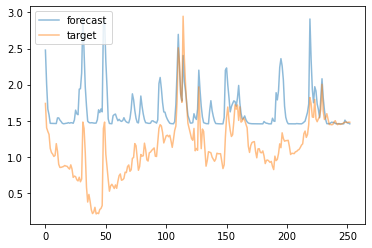

In [196]:
exog, target = get_features_with_residual(test_df, season_cycle, max_lag=3)
get_forecast(exog, target, results)